In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from NetEmbs import *

In [3]:
d_truth = upload_JournalEntriesTruth("Simulation/FSN_Data_v2.db")

In [4]:
import time
from pathos.multiprocessing import ProcessPool
import itertools
import os
import sys
from tqdm import *
from tqdm import tnrange, tqdm_notebook
import pickle
CONFIG.WORK_FOLDER = ("July5/RefactoringExperiments" + path_postfix_samplings, path_postfix_tf)
global global_version, global_walk_length, global_walks_per_node, global_direction
def get_size(obj, seen=None):
    """Recursively finds size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size

def wrappedRandomWalk(node):
#     print(CONFIG.WALKS_LENGTH)
    return [randomWalk(GLOBAL_FSN, node, global_walk_length, direction=CONFIG.DIRECTION, version=global_version) for _
            in range(global_walks_per_node)]
def graph_sampling(n_jobs=4, version="MetaDiff", walk_length=None, walks_per_node=None, direction="COMBI"):
    """
    Construction a sequences of nodes from given FSN
    :param fsn: Researched FSN
    :param n_jobs: Number of parallel processes to be created
    :param version: Applying version of step method
    "DefUniform" - Pure RandomWalk (uniform probabilities, follows the direction),
    "DefWeighted" - RandomWalk (weighted probabilities, follows the direction),
    "MetaUniform" - Default Metapath-version (uniform probabilities, change directions),
    "MetaWeighted" - Weighted Metapath version (weighted probabilities "rich gets richer", change directions),
    "MetaDiff" - Modified Metapath version (probabilities depend on the differences between edges, change directions)
    :param walk_length: max length of RandomWalk
    :param walks_per_node: max number of RandomWalks per each node in FSN
    :param direction: initial direction
    :return: array of sampled nodes
    """
    if walks_per_node is None:
        walks_per_node = CONFIG.WALKS_PER_NODE
    if walk_length is None:
        walk_length = CONFIG.WALKS_LENGTH
    max_processes = min(n_jobs, os.cpu_count())
    pool = ProcessPool(nodes=max_processes)
    BPs = GLOBAL_FSN.get_BP()
    n_BPs = len(BPs)
    sampled = list()
    # all_arguments = zip(BPs, [version] * n_BPs, [walk_length] * n_BPs, [walks_per_node] * n_BPs,
    #                     [direction] * n_BPs)
    if LOG:
        local_logger = logging.getLogger("NetEmbs.Utils.graph_sampling")
        local_logger.info("Created a Pool with " + str(max_processes) + " processes ")
        local_logger.info("Total size of broadcasting arguments is " + str(get_size(BPs)) + " bytes ")
        local_logger.info("Total size of FSN is " + str(get_size(GLOBAL_FSN)) + " bytes ")

    if direction not in ["ALL", "IN", "OUT", "COMBI", "RANDOM"]:
        raise ValueError(
            "Given not supported yet direction of walking {!s}!".format(version) + "\nAllowed only " + str(
                ["ALL", "IN", "OUT"]))
    if direction == "ALL":
        #     Apply RandomWalk for both IN and OUT direction
        # sampled = [randomWalk(fsn, node, walk_length, direction="IN", version=version) for _ in
        #            range(walks_per_node) for node
        #            in fsn.get_BP()] + [randomWalk(fsn, node, walk_length, direction="OUT", version=version)
        #                                for _
        #                                in
        #                                range(walks_per_node) for node
        #                                in fsn.get_BP()]
        print("Chosen ALL direction, hence, run both IN and OUT randomWalks from each node...")
        if LOG:
            local_logger = logging.getLogger("NetEmbs.Utils.graph_sampling")
            local_logger.info("Chosen direction ALL, hence, run both IN and OUT randomWalks from each node! ")
        try:
            with tqdm(total=n_BPs) as pbar:
                for i, res in tqdm_notebook(enumerate(
                        pool.uimap(wrappedRandomWalkIN, BPs))):
                    sampled.append(res)
                    pbar.update()
        except KeyboardInterrupt:
            print('got ^C while pool mapping, terminating the pool')
            pool.terminate()
        pool.terminate()
        pool.restart()
        print("Done with IN direction!")
        try:
            with tqdm(total=n_BPs) as pbar:
                for i, res in tqdm_notebook(enumerate(
                        pool.uimap(wrappedRandomWalkOUT, BPs))):
                    sampled.append(res)
                    pbar.update()
        except KeyboardInterrupt:
            print('got ^C while pool mapping, terminating the pool')
            pool.terminate()
    elif direction in ["COMBI", "IN", "OUT", "RANDOM"]:
        # sampled = [wrappedRandomWalk(node) for node in tqdm(GLOBAL_FSN.get_BP())]
        try:
            with tqdm(total=n_BPs) as pbar:
                for i, res in tqdm_notebook(enumerate(
                        pool.uimap(wrappedRandomWalk, BPs))):
                    sampled.append(res)
                    pbar.update()
            # sampled = pool.uimap(wrappedRandomWalk, [fsn] * n_BPs, BPs, [version] * n_BPs, [walk_length] * n_BPs,
            #                    [walks_per_node] * n_BPs, [direction] * n_BPs)
            # sampled = pool.map(wrappedRandomWalk, [fsn] * n_BPs, BPs, [version] * n_BPs, [walk_length] * n_BPs,
            #                    [walks_per_node] * n_BPs, [direction] * n_BPs)
            # while not sampled.ready():
            #     time.sleep(1)
            #     print(".", end=' ')
            # sampled = sampled.get()
        except KeyboardInterrupt:
            print('got ^C while pool mapping, terminating the pool')
            pool.terminate()
    res = list(itertools.chain(*sampled))
    pool.terminate()
    pool.restart()
    return res
def make_pairs(sampled_seq, window=None, debug=False):
    """
    Helper function for construction pairs from sequence of nodes with given window size
    :param sampled_seq: Original sequence of nodes (output of RandomWalk procedure)
    :param window: window size, how much predecessors and successors one takes into account
    :param debug: print intermediate stages
    :return:
    """
    if debug:
        print(sampled_seq)
    output = list()
    if window is None:
        window = CONFIG.WINDOW_SIZE
    try:
        for cur_idx in range(len(sampled_seq)):
            for drift in range(max(0, cur_idx - window), min(cur_idx + window + 1, len(sampled_seq))):
                if drift != cur_idx:
                    output.append((sampled_seq[cur_idx], sampled_seq[drift]))
        if len(output) < 2 and debug:
            print(output)
        return output
    except TypeError:
        print("t")

def get_pairs(n_jobs=4, version="MetaDiff", walk_length=10, walks_per_node=10, direction="COMBI",
              drop_duplicates=True, use_cache=True):
    """
    Construction a pairs (skip-grams) of nodes according to sampled sequences
    :param fsn: Researched FSN
    :param n_jobs: Number of parallel processes to be created
    :param version: Applying version of step method
    "DefUniform" - Pure RandomWalk (uniform probabilities, follows the direction),
    "DefWeighted" - RandomWalk (weighted probabilities, follows the direction),
    "MetaUniform" - Default Metapath-version (uniform probabilities, change directions),
    "MetaWeighted" - Weighted Metapath version (weighted probabilities "rich gets richer", change directions),
    "MetaDiff" - Modified Metapath version (probabilities depend on the differences between edges, change directions)
    :param walk_length: max length of RandomWalk
    :param walks_per_node: max number of RandomWalks per each node in FSN
    :param direction: initial direction
    :param drop_duplicates: True, delete pairs with equal elements
    :return: array of pairs(joint appearance of two BP nodes)
    """
    if direction not in ["ALL", "IN", "OUT", "COMBI", "RANDOM"]:
        raise ValueError(
            "Given not supported yet direction of walking {!s}!".format(version) + "\nAllowed only " + str(
                ["ALL", "IN", "OUT", "COMBI", "RANDOM"]))
    if not use_cache:
        if PRINT_STATUS:
            print("--------- Started the SAMPLING the sequences from FSN ---------")

        start_time = time.time()
        sequences = graph_sampling(n_jobs, version, direction=direction)
#         sequences.extend(graph_sampling(n_jobs, version, direction=direction))
        end_time = time.time()
        print("Elapsed time for sampling: ", end_time - start_time)
        print("Cashing sampled sequences...")
        with open(CONFIG.WORK_FOLDER[0] + "sampled_seqs_cached.pkl", "wb") as file:
            pickle.dump(sequences, file)
    elif use_cache:
        print("Loading sequences from cache... wait...")
        try:
            with open(CONFIG.WORK_FOLDER[0] + "sampled_seqs_cached.pkl", "rb") as file:
                sequences = pickle.load(file)
        except FileNotFoundError:
            print("File not found... Recalculate \n")
            print("Sampling sequences... wait...")
            start_time = time.time()
            sequences = graph_sampling(n_jobs, version, walk_length, walks_per_node, direction)
            end_time = time.time()
            print("Elapsed time for sampling: ", end_time - start_time)
            print("Cashing sampled sequences...")
            with open(CONFIG.WORK_FOLDER[0] + "sampled_seqs_cached.pkl", "wb") as file:
                pickle.dump(sequences, file)
    if PRINT_STATUS:
        print("--------- Ended the SAMPLING the sequences from FSN ---------")
    max_processes = min(n_jobs, os.cpu_count())
    pool = ProcessPool(nodes=max_processes)
    if PRINT_STATUS:
        print("--------- Started making pairs from the sequences ---------")
    pairs = pool.map(make_pairs, sequences)
    if PRINT_STATUS:
        print("--------- Ended making pairs from the sequences ---------")
    if drop_duplicates:
        pairs = [item for sublist in pairs for item in sublist if item[0] != item[1]]
    else:
        pairs = [item for sublist in pairs for item in sublist]
    pool.terminate()
    pool.restart()
    if LOG:
        local_logger = logging.getLogger("NetEmbs.Utils.get_pairs")
        local_logger.info("Total number of raw sampled pairs is " + str(len(pairs)))
    return pairs

def get_SkipGrams(df, version="MetaDiff", walk_length=10, walks_per_node=10, direction="COMBI", use_cache=False):
    """
    Get Skip-Grams for given DataFrame with Entries records
    :param df: original DataFrame
    :param version: Version of step:
    "DefUniform" - Pure RandomWalk (uniform probabilities, follows the direction),
    "DefWeighted" - RandomWalk (weighted probabilities, follows the direction),
    "MetaUniform" - Default Metapath-version (uniform probabilities, change directions),
    "MetaWeighted" - Weighted Metapath version (weighted probabilities "rich gets richer", change directions),
    "MetaDiff" - Modified Metapath version (probabilities depend on the differences between edges, change directions)
    :param walk_length: max length of RandomWalk
    :param walks_per_node: max number of RandomWalks per each node in FSN
    :param direction: initial direction
    :param use_cache: If True, cache the intermediate SkipGrams sequences
    :return: list of all pairs
    :return fsn: FSN class instance for given DataFrame
    :return tr: Encoder/Decoder for given DataFrame
    """
    # TODO check current version vs. CONFIG.GLOBAL_FSN
    global GLOBAL_FSN
    GLOBAL_FSN = FSN()
    GLOBAL_FSN.build(df, left_title="FA_Name")
    global global_version, global_walk_length, global_walks_per_node, global_direction
    # Global variables for using in forked sub-processes in parallel execution
    global_direction = direction
    global_version = version
    global_walk_length = walk_length
    global_walks_per_node = walks_per_node
    print("Start sampling... wait...")
    skip_gr = get_pairs(N_JOBS, version, walk_length, walks_per_node, CONFIG.DIRECTION, use_cache=use_cache)
    return skip_gr

## Upload data

In [5]:
DB_PATH = "Simulation/FSN_Data_v2.db"
d = upload_data(DB_PATH, limit=1000)
d = prepare_data(d)

Final shape of DataFrame is  (958, 9)


In [6]:
from NetEmbs.utils.IO import *
create_working_folder()

Working directory is  July5/RefactoringExperiments_versionMetaDiff_directionCOMBI_walks30_pressure30_window2/TFsteps100000batch64_emb32/


In [7]:
# CONFIG.WINDOW_SIZE = 3
# CONFIG.PRESSURE = 10
# CONFIG.WALKS_PER_NODE = 30
# CONFIG.WALKS_LENGTH = 10
print(f"Current config parameters: \n WALKS_PER_NODE={CONFIG.WALKS_PER_NODE}, \n walk_length={CONFIG.WALKS_LENGTH}")
print(f"PRESSURE={CONFIG.PRESSURE} \n WINDOW_SIZE={CONFIG.WINDOW_SIZE}")
cur_pairs = get_SkipGrams(d, walks_per_node=CONFIG.WALKS_PER_NODE, \
                          walk_length=CONFIG.WALKS_LENGTH, use_cache=False)

Current config parameters: 
 WALKS_PER_NODE=30, 
 walk_length=10
PRESSURE=30 
 WINDOW_SIZE=2
Start sampling... wait...
--------- Started the SAMPLING the sequences from FSN ---------


  0%|          | 0/164 [00:00<?, ?it/s]

100%|██████████| 164/164 [00:02<00:00, 78.32it/s]


Elapsed time for sampling:  2.2804198265075684
Cashing sampled sequences...
--------- Ended the SAMPLING the sequences from FSN ---------
--------- Started making pairs from the sequences ---------
--------- Ended making pairs from the sequences ---------


In [8]:
def countNext(df):
    c=df.groupby("Next").count()
    return pd.Series(dict(zip(list(c.T), c.T.values[0])))

In [9]:
map_truth = dict(zip(d_truth.ID.values, d_truth.GroundTruth.values))
cur_truth = pd.DataFrame(data=[[map_truth[pair[0]], map_truth[pair[1]]] for pair in cur_pairs], columns=["Current", "Next"])
final_df = cur_truth.groupby("Current").apply(countNext).reset_index()\
        .pivot(index='Current', columns='level_1', values=0).fillna(0)
del final_df.index.name
del final_df.columns.name
final_df

,Collections,Depreciation,Disbursement,Fixed Assets,Good delivery,Payroll,Payroll Disbursement,Purchase,Sales 21 btw,Sales 6 btw,Sales tax
Collections,18650.0,0.0,4404.0,795.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Depreciation,0.0,5814.0,3.0,9.0,3.0,23.0,0.0,3.0,2.0,0.0,0.0
Disbursement,4404.0,3.0,3196.0,2747.0,2.0,0.0,0.0,0.0,0.0,7.0,0.0
Fixed Assets,795.0,9.0,2747.0,4170.0,9.0,3.0,0.0,0.0,5.0,21.0,0.0
Good delivery,0.0,3.0,2.0,9.0,34388.0,18.0,0.0,0.0,14.0,23.0,0.0
Payroll,0.0,23.0,0.0,3.0,18.0,16850.0,0.0,6.0,620.0,163.0,0.0
Payroll Disbursement,0.0,0.0,0.0,0.0,0.0,0.0,2886.0,0.0,0.0,0.0,3717.0
Purchase,0.0,3.0,0.0,0.0,0.0,6.0,0.0,746.0,0.0,0.0,0.0
Sales 21 btw,0.0,2.0,0.0,5.0,14.0,620.0,0.0,0.0,9574.0,6591.0,0.0
Sales 6 btw,0.0,0.0,7.0,21.0,23.0,163.0,0.0,0.0,6591.0,10626.0,0.0


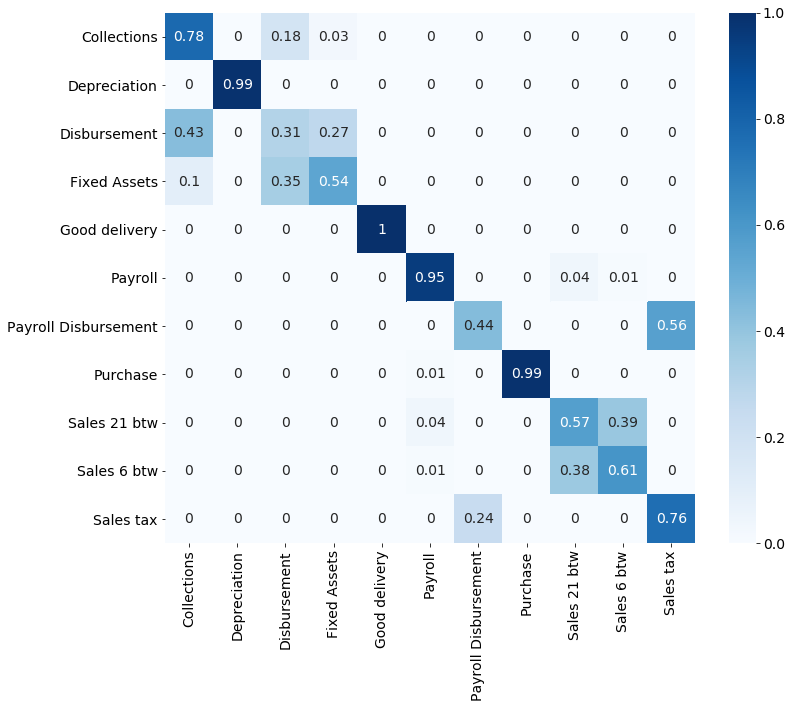

In [10]:
import seaborn as sns
set_font(14)
plt.figure(figsize=(12, 10))
sns.heatmap(final_df.apply(lambda x: round(x/x.sum(), 2), axis=1), cmap="Blues", annot=True, square=True) 
# plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("img/SensitivityAnalysis/Middle_finWalk_winSize"+str(CONFIG.WINDOW_SIZE)\
            +"_walks"+str(CONFIG.WALKS_PER_NODE)\
            +"_length"+str(CONFIG.WALKS_LENGTH) \
            +"_pressure"+str(CONFIG.PRESSURE), dpi=140, pad_inches=0.01)

In [11]:
cur_truth.shape

(156972, 2)